In [1]:
!pip -q install torchio monai medpy wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 50.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00:00:0

In [2]:
import tarfile
import os

# Define file paths
input_tar_path = '/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar'
output_dir = '/kaggle/working/extracted_data'


# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Extract tar file
with tarfile.open(input_tar_path, 'r') as tar:
   tar.extractall(path=output_dir)

print(f"Extraction complete! Files are saved in: {output_dir}")


Extraction complete! Files are saved in: /kaggle/working/extracted_data


In [3]:
import os
import wandb
import numpy as np
import nibabel as nib
from glob import glob
from tqdm import tqdm
from statistics import mean
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchio as tio
from torchio.data import SubjectsLoader, SubjectsDataset

from monai.networks.nets import SwinUNETR
from monai.losses import DiceLoss, DiceCELoss

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.__version__, device



<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-07-02 16:22:45.667929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751473365.881896      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751473365.942649      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


('2.6.0+cu124', device(type='cuda'))

In [4]:
from torch.utils.data import Dataset
import torchio as tio
import os
from glob import glob
import torch.nn.functional as F


NUM_CLASSES = 4  # Update this based on your actual classes

class LazySegmentationDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, WT=False):
        self.transform = transform
        
        # Just store file paths
        self.flair_paths = sorted(glob(os.path.join(root_dir, "**", "*flair*.nii.gz"), recursive=True))
        self.t1_paths = sorted(glob(os.path.join(root_dir, "**", "*t1.nii.gz"), recursive=True))
        self.t1ce_paths = sorted(glob(os.path.join(root_dir, "**", "*t1ce*.nii.gz"), recursive=True))
        self.t2_paths = sorted(glob(os.path.join(root_dir, "**", "*t2.nii.gz"), recursive=True))
        self.mask_paths = sorted(glob(os.path.join(root_dir, "**", "*seg*.nii.gz"), recursive=True))
        
        assert len(self.flair_paths) == len(self.t1_paths) == len(self.t1ce_paths) == len(self.t2_paths) == len(self.mask_paths), \
            "Mismatch in number of images"
        
        self.subject_paths = list(zip(self.flair_paths, self.t1_paths, self.t1ce_paths, self.t2_paths, self.mask_paths))
    
    def __len__(self):
        return len(self.subject_paths)
    


    def __getitem__(self, idx):
        flair_path, t1_path, t1ce_path, t2_path, mask_path = self.subject_paths[idx]
    
        subject = tio.Subject(
            flair=tio.ScalarImage(flair_path),
            t1=tio.ScalarImage(t1_path),
            t1ce=tio.ScalarImage(t1ce_path),
            t2=tio.ScalarImage(t2_path),
            mask=tio.LabelMap(mask_path),
        )
    
        if self.transform:
            subject = self.transform(subject)
    
        # 1. Remap label 4 to 3
        mask_tensor = subject['mask'][tio.DATA]  # [1, H, W, D]
        mask_tensor[mask_tensor == 4] = 3
        mask_tensor = mask_tensor.long()
    
        # 2. Remove channel dimension before one-hot encoding: [1, H, W, D] → [H, W, D]
        mask_tensor = mask_tensor.squeeze(0)
        if WT:
            mask_tensor[mask_tensor >=1] = 1
            NUM_CLASSES=2
            # 3. One-hot encode: [H, W, D] → [C, H, W, D]
            mask_onehot = F.one_hot(mask_tensor, num_classes=NUM_CLASSES).permute(3, 0, 1, 2).float()
        else:
            NUM_CLASSES=4
            mask_onehot = F.one_hot(mask_tensor, num_classes=NUM_CLASSES).permute(3, 0, 1, 2).float()
    
        # 4. Replace mask with one-hot version
        subject['mask'].set_data(mask_onehot)

        return subject

In [5]:
transforms = tio.Compose([
    tio.ToCanonical(),
    tio.ZNormalization(),
    tio.Resample((2.4, 2.4, 2.2)),
    tio.RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 99.5)),
    tio.CropOrPad((96, 96, 96)),
])

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
WT=False

full_dataset = LazySegmentationDataset('DATA PATH', transform=transforms,WT=WT)


# Define split lengths
total_size = len(full_dataset)
train_size = int(0.85 * total_size)
# val_size = int(0.15 * total_size)
val_size = total_size - train_size #- val_size

# Optional: set manual seed for reproducibility
generator = torch.Generator().manual_seed(42)

# train_dataset, val_dataset, test_dataset = random_split(
#     full_dataset, [train_size, val_size, test_size], generator=generator
# )

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size], generator=generator
)
train_loader = SubjectsLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader   = SubjectsLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)
# test_loader  = SubjectsLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)


In [7]:
len(train_loader), len(val_loader)#, len(test_loader)

(532, 94)

In [8]:
import torch
import random
import math

def generate_3d_patch_mask(volume_shape, patch_size=(16, 16, 16), mask_ratio=0.75):
    """
    Generate binary mask for random 3D patches.

    Args:
        volume_shape: tuple (B, C, H, W, D)
        patch_size: tuple (pH, pW, pD)
        mask_ratio: float in [0, 1], fraction of patches to mask

    Returns:
        Tensor of shape [B, 1, H, W, D] with 1s in masked regions
    """
    B, C, H, W, D = volume_shape
    pH, pW, pD = patch_size

    # Number of patches in each dimension
    num_patches = (H // pH, W // pW, D // pD)
    total_patches = num_patches[0] * num_patches[1] * num_patches[2]
    num_masked = math.ceil(mask_ratio * total_patches)

    mask = torch.zeros((B, 1, H, W, D), dtype=torch.float32)

    for b in range(B):
        # Generate random patch indices
        all_indices = [(i, j, k) 
                       for i in range(num_patches[0]) 
                       for j in range(num_patches[1]) 
                       for k in range(num_patches[2])]
        masked_indices = random.sample(all_indices, num_masked)

        for (i, j, k) in masked_indices:
            h_start = i * pH
            w_start = j * pW
            d_start = k * pD
            mask[b, 0, h_start:h_start+pH, w_start:w_start+pW, d_start:d_start+pD] = 1.0
            # Apply masking to the input
    if mask.shape[1] == 1 and volume_shape[1] > 1:
        mask = mask.repeat(1, volume_shape[1], 1, 1, 1)  # Now [B, 4, H, W, D]

    return mask


In [9]:
import torch
import torch.nn as nn
from monai.networks.nets import SwinUNETR


In [11]:
class SwinUNetRMaskedAutoencoder1(nn.Module):
    def __init__(self, img_size=96, in_channels=4, patch_size=2):
        super().__init__()
        self.encoder = SwinUNETR(
            
            in_channels=in_channels,
            out_channels=4,  # Dummy output
            feature_size=48,
            use_checkpoint=False
        )
        self.encoder.out = nn.Sequential(
            nn.Conv3d(48, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(32, in_channels, kernel_size=3, padding=1)  # Reconstruct all modalities
        )

    def forward(self, x):
        encoded = self.encoder(x)
        # decoded = self.decoder(encoded)
        return encoded


In [56]:
original=SwinUNETR(in_channels=4,
            out_channels=4,  # Dummy output
            feature_size=48,
            use_checkpoint=False
        )

original.out

UnetOutBlock(
  (conv): Convolution(
    (conv): Conv3d(48, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
)

In [12]:
# SwinUNetRMaskedAutoencoder1()

In [13]:
def compute_reconstruction_metrics(pred, target, mask=None):
    """
    Computes voxel-wise reconstruction metrics (MAE, MSE, PSNR) on masked regions.

    Args:
        pred (Tensor): Reconstructed output [B, C, H, W, D]
        target (Tensor): Ground truth [B, C, H, W, D]
        mask (Tensor): Binary mask [B, 1 or C, H, W, D] — 1 where masked, 0 otherwise

    Returns:
        List[Dict]: Per-modality metrics and average
    """
    pred = pred.detach().cpu()
    target = target.detach().cpu()
    if mask is not None:
        mask = mask.detach().cpu()
        if mask.shape[1] == 1:
            mask = mask.repeat(1, pred.shape[1], 1, 1, 1)  # Expand to all channels

    metrics = {'MAE': [], 'MSE': [], 'PSNR': []}
    per_modality_results = []

    for c in range(pred.shape[1]):
        pred_c = pred[:, c]
        target_c = target[:, c]
        mask_c = mask[:, c] if mask is not None else torch.ones_like(target_c)

        # Apply mask
        masked_pred = pred_c[mask_c > 0]
        masked_target = target_c[mask_c > 0]

        if masked_pred.numel() == 0:
            mae = mse = 0.0
            psnr = float('inf')
        else:
            mae = F.l1_loss(masked_pred, masked_target, reduction='mean').item()
            mse = F.mse_loss(masked_pred, masked_target, reduction='mean').item()
            psnr = 20 * np.log10(1.0) - 10 * np.log10(mse) if mse > 0 else float('inf')

        per_modality_results.append({
            'Modality': f'Modality_{c+1}',
            'MAE': round(mae, 5),
            'MSE': round(mse, 5),
            'PSNR': round(psnr, 2)
        })

        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['PSNR'].append(psnr)

    avg_metrics = {
        'Modality': 'Average',
        'MAE': round(np.mean(metrics['MAE']), 5),
        'MSE': round(np.mean(metrics['MSE']), 5),
        'PSNR': round(np.mean(metrics['PSNR']), 2)
    }

    return avg_metrics#per_modality_results + [avg_metrics]


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.losses import SSIMLoss

class MaskedReconstructionLoss(nn.Module):
    def __init__(self, use_ssim=False, ssim_weight=0.5):
        """
        Args:
            use_ssim (bool): If True, include SSIM in the loss
            ssim_weight (float): Weight of SSIM loss if used (1 - ssim_weight used for L1)
        """
        super().__init__()
        self.use_ssim = use_ssim
        self.ssim_weight = ssim_weight
        self.l1 = nn.L1Loss(reduction='none')
        if use_ssim:
            self.ssim = SSIMLoss(spatial_dims=3, data_range=1.0)

    def forward(self, pred, target, mask):
        """
        Args:
            pred: predicted volume [B, C, H, W, D]
            target: ground truth volume [B, C, H, W, D]
            mask: binary mask [B, 1 or C, H, W, D], 1 where masked

        Returns:
            Scalar loss
        """
        if mask.shape[1] == 1:
            mask = mask.repeat(1, pred.shape[1], 1, 1, 1)

        pred_masked = pred * mask
        target_masked = target * mask

        if self.use_ssim:
            l1_loss = self.l1(pred_masked, target_masked)
            l1_loss = l1_loss.sum() / mask.sum().clamp(min=1)

            ssim_loss = self.ssim(pred_masked, target_masked)
            total_loss = self.ssim_weight * ssim_loss + (1 - self.ssim_weight) * l1_loss
        else:
            l1_loss = self.l1(pred_masked, target_masked)
            total_loss = l1_loss.sum() / mask.sum().clamp(min=1)

        return total_loss


In [15]:

# import wandb

# # Login (optional — usually set via environment or CLI for security)
# wandb.login(key="")

# # Initialize project
# wandb.init(
#     project="",
#     name="",
#     config={
#         "epochs": 100,
#         "batch_size": 1,
#         "img_size": (96, 96, 96),
#         "model": "SwinUNETR",
#         "loss": "Masked SSIM + L1",  # If using for SSL
#     }
# )

In [16]:
import torch
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, recon_loss_fn, patch_size, mask_ratio=0.75):
    model.train()
    running_loss = 0.0

    for batch in tqdm(loader):
        # Prepare input
        x = torch.cat([
            batch['flair'][tio.DATA],
            batch['t1'][tio.DATA],
            batch['t1ce'][tio.DATA],
            batch['t2'][tio.DATA],
        ], dim=1).to(device)  # Shape: [B, 4, H, W, D]

        # Generate a new random mask per batch
        mask = generate_3d_patch_mask(
            volume_shape=x.shape,
            patch_size=patch_size,
            mask_ratio=mask_ratio
        ).to(device)  # Shape: [B, 1, H, W, D]


        x_input = x.clone()
        x_input[mask.bool()] = 0.0

        # Forward and loss
        optimizer.zero_grad()
        recon_image = model(x_input)  # Input is masked version
        loss = recon_loss_fn(recon_image, x, mask)  # Target is original x
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)



In [17]:
def average_metric_dicts(metrics_list):
    """
    Averages a list of metric dicts (from each batch).
    """
    from collections import defaultdict
    import numpy as np

    avg_metrics = defaultdict(list)

    for m in metrics_list:
        
        for k, v in m.items():
            if k!="Modality":
                avg_metrics[k].append(v)

    return {k: np.mean(v) for k, v in avg_metrics.items()}


In [18]:
@torch.no_grad()
def validate(model, loader, recon_loss_fn, patch_size, mask_ratio=0.75):
    model.eval()
    val_loss = 0.0
    metric_accumulator = []

    for batch in tqdm(loader):
        x = torch.cat([
            batch['flair'][tio.DATA],
            batch['t1'][tio.DATA],
            batch['t1ce'][tio.DATA],
            batch['t2'][tio.DATA],
        ], dim=1).to(device)

        mask = generate_3d_patch_mask(
            volume_shape=x.shape,
            patch_size=patch_size,
            mask_ratio=mask_ratio
        ).to(x.device)

        x_input = x.clone()
        x_input[mask.bool()] = 0.0

        recon = model(x_input)
        loss = recon_loss_fn(recon, x, mask)
        val_loss += loss.item()

        # Compute batch-level metrics
        batch_metrics = compute_reconstruction_metrics(recon.cpu(), x.cpu(), mask.cpu())
        metric_accumulator.append(batch_metrics)

    avg_val_loss = val_loss / len(loader)

    # Average metrics over all batches
    final_metrics = average_metric_dicts(metric_accumulator)
    return avg_val_loss, final_metrics


In [19]:
@torch.no_grad()
def one_validate(model, loader, recon_loss_fn, patch_size, mask_ratio=0.75):
    model.eval()
    val_loss = 0.0
    metric_accumulator = []

    for batch in tqdm(loader):
        x = torch.cat([
            batch['flair'][tio.DATA],
            batch['t1'][tio.DATA],
            batch['t1ce'][tio.DATA],
            batch['t2'][tio.DATA],
        ], dim=1).to(device)

        mask = generate_3d_patch_mask(
            volume_shape=x.shape,
            patch_size=patch_size,
            mask_ratio=mask_ratio
        ).to(x.device)

        x_input = x.clone()
        x_input[mask.bool()] = 0.0
        
        recon = model(x_input)
        loss = recon_loss_fn(recon, x, mask)
        val_loss += loss.item()

        # Compute batch-level metrics
        batch_metrics = compute_reconstruction_metrics(recon.cpu(), x.cpu(), mask.cpu())
        metric_accumulator.append(batch_metrics)
        break
    # avg_val_loss = val_loss / len(loader)

    # Average metrics over all batches
    # final_metrics = average_metric_dicts(metric_accumulator)
    return x, x_input, mask,recon

## Testing the Trained Model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameters
num_epochs = 100
patch_size = (8, 8, 8)
mask_ratio = 0.30
recon_loss_fn = MaskedReconstructionLoss(use_ssim=True, ssim_weight=0.4)
Recon_model=SwinUNetRMaskedAutoencoder1(img_size=96, in_channels=4, patch_size=2)
Recon_model = torch.nn.DataParallel(Recon_model, device_ids=[0, 1])  # Use GPU 0 and GPU 1
Recon_model = Recon_model.to(device)

Recon_model.load_state_dict(torch.load('PATH TO YOUR MODEL'))

<All keys matched successfully>

In [26]:
x, x_input, mask,recon=one_validate(Recon_model, val_loader, recon_loss_fn, patch_size, mask_ratio=0.3)

  0%|          | 0/94 [00:07<?, ?it/s]


In [ ]:
x.shape

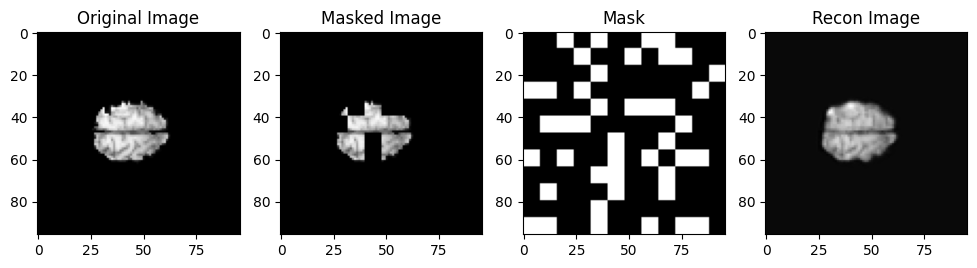

In [46]:
slice=np.random.randint(1,x.shape[-1])
i=1
plt.figure(figsize=(12,6))
plt.subplot(1,4,1)
plt.imshow(x[0,i, :,:,slice].cpu(),cmap='gray')
plt.title("Original Image")
plt.subplot(1,4,2)
plt.imshow(x_input[0,i, :,:,slice].cpu(),cmap='gray')
plt.title("Masked Image")
plt.subplot(1,4,3)
plt.imshow(mask[0,i, :,:,slice].cpu(),cmap='gray')
plt.title("Mask")
plt.subplot(1,4,4)
plt.imshow(recon[0,i, :,:,slice].cpu(),cmap='gray')
plt.title("Recon Image")
plt.show()

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Recon_model=SwinUNetRMaskedAutoencoder1(96).to(device)

Recon_model = torch.nn.DataParallel(Recon_model, device_ids=[0, 1])  # Use GPU 0 and GPU 1
Recon_model = Recon_model.to(device)
Recon_model.load_state_dict(torch.load("/kaggle/input/swin_ssl/pytorch/default/1/best_swinunetr_ssl.pth"))
optimizer = torch.optim.AdamW(Recon_model.parameters(), lr=1e-4)

# Define SSL loss function
recon_loss_fn = MaskedReconstructionLoss(use_ssim=True, ssim_weight=0.4)

# Hyperparameters
num_epochs = 100
patch_size = (8, 8, 8)
mask_ratio = 0.30
best_val_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(
        model=Recon_model,
        loader=train_loader, #change here
        optimizer=optimizer,
        recon_loss_fn=recon_loss_fn,
        patch_size=patch_size,
        mask_ratio=mask_ratio
    )

    val_loss, val_metrics = validate(
        model=Recon_model,
        loader=val_loader,
        recon_loss_fn=recon_loss_fn,
        patch_size=patch_size,
        mask_ratio=mask_ratio
    )

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Log basic losses
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
    })

    # Log reconstruction metrics
    # for metric in val_metrics:
        # modality = metric['Modality']
    wandb.log({
        "MAE": val_metrics['MAE'],
        "MSE": val_metrics['MSE'],
        "/PSNR": val_metrics['PSNR'],
    })

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(Recon_model.state_dict(), "best_swinunetr_ssl_extended.pth")


 11%|█         | 56/532 [07:45<1:06:00,  8.32s/it]


KeyboardInterrupt: 